In [306]:
import pandas as pd
import io
import requests
import numpy as np
import matplotlib.pyplot as plt

## Download Data

In [484]:
if False:
    year_data = []
    for year in range(2000, 2026):
        response = requests.get(f'http://www.tennis-data.co.uk/{year}/{year}.xlsx')
        d = pd.read_excel(io.BytesIO(response.content))
        year_data.append(d)

    raw_matches = pd.concat(year_data, ignore_index=True)
    raw_matches["Date"] = pd.to_datetime(raw_matches["Date"]).dt.date
    raw_matches.to_csv("../data/raw/allyears.csv", index=False)
else:
    raw_matches = pd.read_csv("../data/raw/allyears.csv")
    raw_matches["Date"] = pd.to_datetime(raw_matches["Date"]).dt.date

/var/folders/rt/6gn8r35d7zz_5qcrl1mlqcqh0000gp/T/ipykernel_83658/173528529.py:12: DtypeWarning: Columns (11,12,15,16,17,18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_matches = pd.read_csv("../data/raw/allyears.csv")


## Feature Engineering

NOTES
- Set 5 can have tie breaks. Need to fix eventually. 
- Odds data is missing entirely from 2000, and partly in 2001.

FEATURES TO ADD
- Wins in last 5, 10, 15 games of players 
- Wins in last 5 in the same tournament
- Highest stage reached in the tournament by the player
- Highest stage reached in previous years tournament
- Tournament factor (katsayi)
- Game factor (e.g., finals probably matter more than earlier rounds)

In [485]:
matches = raw_matches[[
    "ATP",
    "Winner",
    "Loser",
    "WRank",
    "LRank",
    "WPts",
    "LPts",
    "Date",
    "Tournament",
    "Round"
]].copy()

odd_cols_w = ["CBW", "GBW", "IWW", "SBW", "B365W", "B&WW", "EXW", "PSW", "UBW", "LBW", "SJW", "BFEW"]
odd_cols_l = ["CBL", "GBL", "IWL", "SBL", "B365L", "B&WL", "EXL", "PSL", "UBL", "LBL", "SJL", "BFEL"]

raw_matches["EXW"] = raw_matches["EXW"].apply(lambda x: x.replace(",", "") if isinstance(x, str) else x).astype(float)
raw_matches[odd_cols_w].replace(0, np.nan, inplace=True)
raw_matches[odd_cols_l].replace(0, np.nan, inplace=True)
matches["avg_oddsW"] = raw_matches[odd_cols_w].mean(axis=1)
matches["avg_oddsL"] = raw_matches[odd_cols_l].mean(axis=1)
matches["max_oddsW"] = raw_matches[odd_cols_w].max(axis=1)
matches["max_oddsL"] = raw_matches[odd_cols_l].max(axis=1)
matches["min_oddsW"] = raw_matches[odd_cols_w].min(axis=1)
matches["min_oddsL"] = raw_matches[odd_cols_l].min(axis=1)

game_cols_w = ["W1", "W2", "W3", "W4", "W5"]
game_cols_l = ["L1", "L2", "L3", "L4", "L5"]
set_cols = ["Wsets", "Lsets"]

for col in game_cols_w + game_cols_l + set_cols:
    raw_matches[col] = raw_matches[col].apply(lambda x: np.nan if isinstance(x, str) else x).astype(float)

raw_matches[game_cols_w + game_cols_l + set_cols] = raw_matches[game_cols_w + game_cols_l + set_cols].fillna(0)

matches["Wgames"] = raw_matches[game_cols_w].sum(axis=1)
matches["Lgames"] = raw_matches[game_cols_l].sum(axis=1)
matches["Wgameratio"] = matches["Wgames"] / matches["Lgames"]
matches["Lgameratio"] = matches["Lgames"] / matches["Wgames"]

# Convert ranking columns to float after handling "NR" and capping at 2000
raw_matches["WRank"] = raw_matches["WRank"].replace("NR", 2000).astype(float)
matches["WRank"] = raw_matches["WRank"].where(raw_matches["WRank"] <= 2000, 2000)

raw_matches["LRank"] = raw_matches["LRank"].replace("NR", 2000).astype(float)
matches["LRank"] = raw_matches["LRank"].where(raw_matches["LRank"] <= 2000, 2000)

matches["WPts"] = raw_matches["WPts"].fillna(0)
matches["LPts"] = raw_matches["LPts"].fillna(0)

matches["rank_diff"] = matches["WRank"] - matches["LRank"]
matches["points_diff"] = matches["WPts"] - matches["LPts"]

matches["month"] = pd.to_datetime(raw_matches["Date"]).dt.month
matches["year"] = pd.to_datetime(raw_matches["Date"]).dt.year

def one_hot_encode(raw_df, df, column_name):
    encoded = pd.get_dummies(raw_df[column_name], prefix=column_name.lower())
    df = pd.concat([df, encoded], axis=1)
    return df

matches = one_hot_encode(raw_matches, matches, "Series")
matches = one_hot_encode(raw_matches, matches, "Surface")
matches = one_hot_encode(raw_matches, matches, "Round")

matches["Outdoor"] = raw_matches["Court"] == "Outdoor"
matches["best_of_5"] = raw_matches["Best of"] == 5

/var/folders/rt/6gn8r35d7zz_5qcrl1mlqcqh0000gp/T/ipykernel_83658/3433104357.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_matches[odd_cols_w].replace(0, np.nan, inplace=True)
/var/folders/rt/6gn8r35d7zz_5qcrl1mlqcqh0000gp/T/ipykernel_83658/3433104357.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_matches[odd_cols_l].replace(0, np.nan, inplace=True)


In [487]:
matches = matches.iloc[::-1].reset_index(drop=True)

In [488]:
winner_last_1_col = []
winner_last_5_col = []
winner_last_15_col = []

winner_last_1_tournament_col = []
winner_last_5_tournament_col = []
winner_last_15_tournament_col = []

winner_last_5_h2h_col = []
winner_last_5_tournament_h2h_col = []

winner_finals_tournament_col = []
winner_last_5_stage_col = []

loser_last_1_col = []
loser_last_5_col = []
loser_last_15_col = []

loser_last_1_tournament_col = []
loser_last_5_tournament_col = []
loser_last_15_tournament_col = []

loser_last_5_h2h_col = []
loser_last_5_tournament_h2h_col = []

loser_finals_tournament_col = []
loser_last_5_stage_col = []


# iterrow matches
for index, row in matches.iterrows():
    tournament_mask = matches["Tournament"] == row["Tournament"]
    date_mask = matches["Date"] < row["Date"]
    loser_mask = (matches["Winner"] == row["Loser"]) | (matches["Loser"] == row["Loser"])
    winner_mask = (matches["Winner"] == row["Winner"]) | (matches["Loser"] == row["Winner"])
    finals_mask = (matches["Round"].isin(["The Final", "Semifinals", "Quarterfinals"]))

    ### features for winner
    
    # wins in last 1, 5, 15 games
    winner_last_1 = (matches.loc[date_mask & winner_mask, "Winner"].iloc[:1] == row["Winner"]).sum()
    winner_last_1_col.append(winner_last_1)
    winner_last_5 = (matches.loc[date_mask & winner_mask, "Winner"].iloc[:5] == row["Winner"]).sum()
    winner_last_5_col.append(winner_last_5)
    winner_last_15 = (matches.loc[date_mask & winner_mask, "Winner"].iloc[:15] == row["Winner"]).sum()
    winner_last_15_col.append(winner_last_15)
    
    # wins in last 1, 5, 15 games of same tournament
    winner_last_1_tournament = (matches.loc[date_mask & winner_mask & tournament_mask, "Winner"].iloc[:1] == row["Winner"]).sum()
    winner_last_1_tournament_col.append(winner_last_1_tournament)
    winner_last_5_tournament = (matches.loc[date_mask & winner_mask & tournament_mask, "Winner"].iloc[:5] == row["Winner"]).sum()
    winner_last_5_tournament_col.append(winner_last_5_tournament)
    winner_last_15_tournament = (matches.loc[date_mask & winner_mask & tournament_mask, "Winner"].iloc[:15] == row["Winner"]).sum()
    winner_last_15_tournament_col.append(winner_last_15_tournament)

    # winner head to head
    winner_last_5_h2h = (matches.loc[date_mask & winner_mask & loser_mask, "Winner"].iloc[:5] == row["Winner"]).sum()
    winner_last_5_h2h_col.append(winner_last_5_h2h)
    winner_last_5_tournament_h2h = (matches.loc[date_mask & winner_mask & loser_mask & tournament_mask, "Winner"].iloc[:5] == row["Winner"]).sum()
    winner_last_5_tournament_h2h_col.append(winner_last_5_tournament_h2h)

    # winner number of times in finals in the tournament
    winner_finals_tournament = (matches.loc[date_mask & winner_mask & tournament_mask & finals_mask, "Winner"].iloc[:5] == row["Winner"]).sum()
    winner_finals_tournament_col.append(winner_finals_tournament)

    # winner last 5 games in this stage
    winner_last_5_stage = (matches.loc[date_mask & winner_mask & (matches["Round"] == row["Round"]), "Winner"].iloc[:5] == row["Winner"]).sum()
    winner_last_5_stage_col.append(winner_last_5_stage)
    
    # TODO highest stage reached in the tournament

    # TODO highest stage reached in previous years tournament

    ### features for loser
    
    # wins in last 1, 5, 15 games
    loser_last_1 = (matches.loc[date_mask & loser_mask, "Winner"].iloc[:1] == row["Loser"]).sum()
    loser_last_1_col.append(loser_last_1)
    loser_last_5 = (matches.loc[date_mask & loser_mask, "Winner"].iloc[:5] == row["Loser"]).sum()
    loser_last_5_col.append(loser_last_5)
    loser_last_15 = (matches.loc[date_mask & loser_mask, "Winner"].iloc[:15] == row["Loser"]).sum()
    loser_last_15_col.append(loser_last_15)

    # wins in last 1, 5, 15 games of same tournament
    loser_last_1_tournament = (matches.loc[date_mask & loser_mask & tournament_mask, "Winner"].iloc[:1] == row["Loser"]).sum()
    loser_last_1_tournament_col.append(loser_last_1_tournament)
    loser_last_5_tournament = (matches.loc[date_mask & loser_mask & tournament_mask, "Winner"].iloc[:5] == row["Loser"]).sum()
    loser_last_5_tournament_col.append(loser_last_5_tournament)
    loser_last_15_tournament = (matches.loc[date_mask & loser_mask & tournament_mask, "Winner"].iloc[:15] == row["Loser"]).sum()
    loser_last_15_tournament_col.append(loser_last_15_tournament)
    
    # loser head to head
    loser_last_5_h2h = (matches.loc[date_mask & loser_mask & winner_mask, "Winner"].iloc[:5] == row["Loser"]).sum()
    loser_last_5_h2h_col.append(loser_last_5_h2h)
    loser_last_5_tournament_h2h = (matches.loc[date_mask & loser_mask & winner_mask & tournament_mask, "Winner"].iloc[:5] == row["Loser"]).sum()
    loser_last_5_tournament_h2h_col.append(loser_last_5_tournament_h2h)

    # loser number of times in finals in the tournament
    loser_finals_tournament = (matches.loc[date_mask & loser_mask & tournament_mask & finals_mask, "Winner"].iloc[:5] == row["Loser"]).sum()
    loser_finals_tournament_col.append(loser_finals_tournament)

    # loser last 5 games in this stage
    loser_last_5_stage = (matches.loc[date_mask & loser_mask & (matches["Round"] == row["Round"]), "Winner"].iloc[:5] == row["Loser"]).sum()
    loser_last_5_stage_col.append(loser_last_5_stage)

In [489]:
# Assign the computed features as columns to the matches DataFrame
matches["last_1_W"] = winner_last_1_col
matches["last_5_W"] = winner_last_5_col
matches["last_15_W"] = winner_last_15_col

matches["last_1_tournament_W"] = winner_last_1_tournament_col
matches["last_5_tournament_W"] = winner_last_5_tournament_col
matches["last_15_tournament_W"] = winner_last_15_tournament_col

matches["last_5_h2h_W"] = winner_last_5_h2h_col
matches["last_5_tournament_h2h_W"] = winner_last_5_tournament_h2h_col

matches["finals_tournament_W"] = winner_finals_tournament_col
matches["last_5_stage_W"] = winner_last_5_stage_col

matches["last_1_L"] = loser_last_1_col
matches["last_5_L"] = loser_last_5_col
matches["last_15_L"] = loser_last_15_col

matches["last_1_tournament_L"] = loser_last_1_tournament_col
matches["last_5_tournament_L"] = loser_last_5_tournament_col
matches["last_15_tournament_L"] = loser_last_15_tournament_col

matches["last_5_h2h_L"] = loser_last_5_h2h_col
matches["last_5_tournament_h2h_L"] = loser_last_5_tournament_h2h_col

matches["finals_tournament_L"] = loser_finals_tournament_col
matches["last_5_stage_L"] = loser_last_5_stage_col


In [490]:
# Rename columns to use A/B instead of Winner/Loser and W/L
column_mapping = {
    # Winner/W columns -> A columns
    'Winner': 'PlayerA',
    'WRank': 'ARank', 
    'WPts': 'APts',
    'avg_oddsW': 'avg_oddsA',
    'max_oddsW': 'max_oddsA',
    'min_oddsW': 'min_oddsA',
    'Wgames': 'Agames',
    'Wgameratio': 'Agameratio',
    'last_1_W': 'last_1_A',
    'last_5_W': 'last_5_A', 
    'last_15_W': 'last_15_A',
    'last_1_tournament_W': 'last_1_tournament_A',
    'last_5_tournament_W': 'last_5_tournament_A',
    'last_15_tournament_W': 'last_15_tournament_A',
    'last_5_h2h_W': 'last_5_h2h_A',
    'last_5_tournament_h2h_W': 'last_5_tournament_h2h_A',
    'finals_tournament_W': 'finals_tournament_A',
    'last_5_stage_W': 'last_5_stage_A',
    
    # Loser/L columns -> B columns  
    'Loser': 'PlayerB',
    'LRank': 'BRank',
    'LPts': 'BPts', 
    'avg_oddsL': 'avg_oddsB',
    'max_oddsL': 'max_oddsB',
    'min_oddsL': 'min_oddsB',
    'Lgames': 'Bgames',
    'Lgameratio': 'Bgameratio',
    'last_1_L': 'last_1_B',
    'last_5_L': 'last_5_B',
    'last_15_L': 'last_15_B', 
    'last_1_tournament_L': 'last_1_tournament_B',
    'last_5_tournament_L': 'last_5_tournament_B',
    'last_15_tournament_L': 'last_15_tournament_B',
    'last_5_h2h_L': 'last_5_h2h_B',
    'last_5_tournament_h2h_L': 'last_5_tournament_h2h_B',
    'finals_tournament_L': 'finals_tournament_B',
    'last_5_stage_L': 'last_5_stage_B'
}

matches = matches.rename(columns=column_mapping)

# Create binary label column where 1 = Player A won, 0 = Player B won
matches['PlayerA_Won'] = 1

## Exploratory Data Analysis

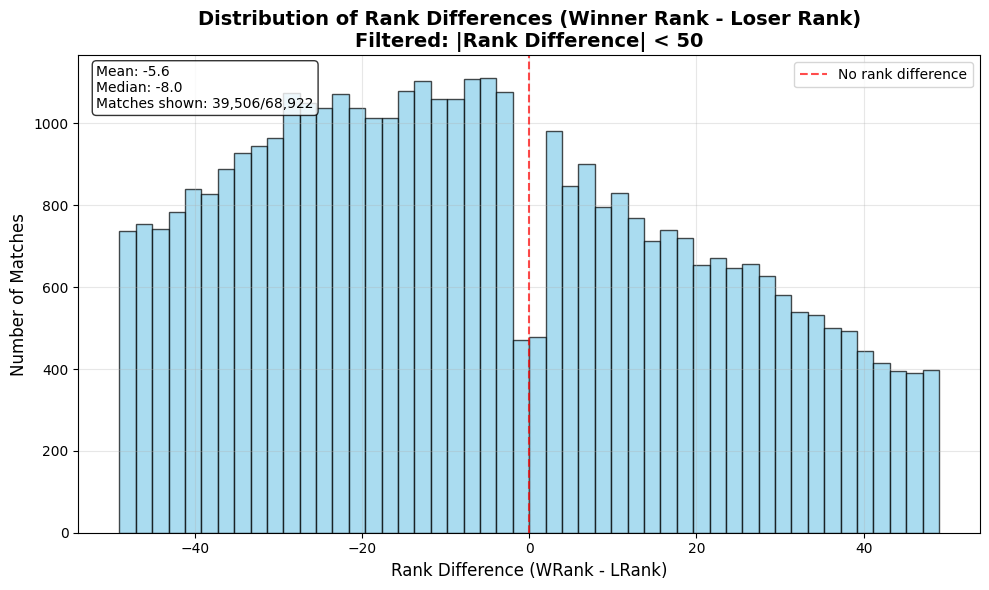

In [309]:
# Create histogram of rank differences for matches with absolute difference < 50
filtered_matches = matches[abs(matches["rank_diff"]) < 50]

plt.figure(figsize=(10, 6))
plt.hist(filtered_matches["rank_diff"], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Rank Differences (Winner Rank - Loser Rank)\nFiltered: |Rank Difference| < 50', fontsize=14, fontweight='bold')
plt.xlabel('Rank Difference (WRank - LRank)', fontsize=12)
plt.ylabel('Number of Matches', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No rank difference')
plt.grid(True, alpha=0.3)
plt.legend()

# Add some statistics text
mean_diff = filtered_matches["rank_diff"].mean()
median_diff = filtered_matches["rank_diff"].median()
total_matches = len(filtered_matches)
original_matches = len(matches)
plt.text(0.02, 0.98, f'Mean: {mean_diff:.1f}\nMedian: {median_diff:.1f}\nMatches shown: {total_matches:,}/{original_matches:,}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()



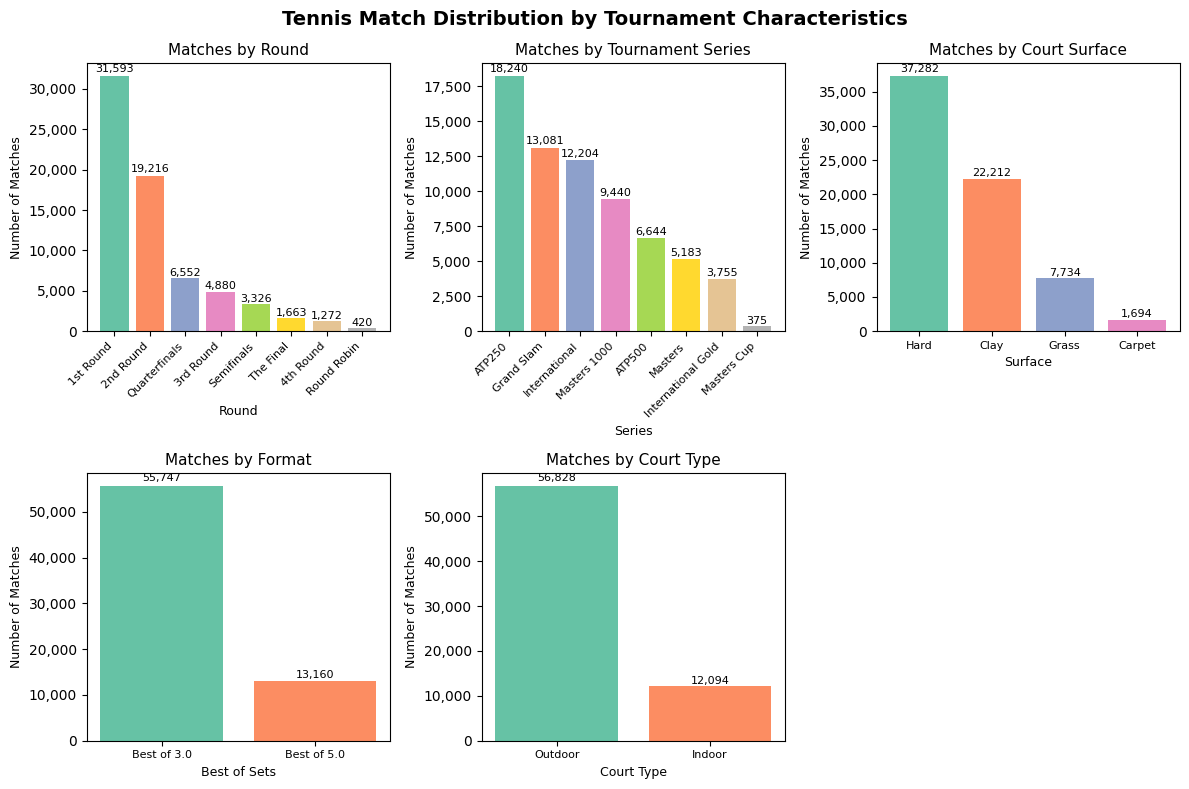

In [307]:
# Set up the figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Tennis Match Distribution by Tournament Characteristics', fontsize=14, fontweight='bold')

# Flatten axes for easier indexing
axes = axes.flatten()

# Define color palette
colors = plt.cm.Set2(range(12))

# Helper function to format numbers with commas
def format_number(x):
    return f"{int(x):,}"

# 1. Round distribution
round_counts = raw_matches['Round'].value_counts()
bars1 = axes[0].bar(range(len(round_counts)), round_counts.values, color=colors[:len(round_counts)])
axes[0].set_title('Matches by Round', fontsize=11)
axes[0].set_xlabel('Round', fontsize=9)
axes[0].set_ylabel('Number of Matches', fontsize=9)
axes[0].set_xticks(range(len(round_counts)))
axes[0].set_xticklabels(round_counts.index, rotation=45, ha='right', fontsize=8)
# Add labels on top of bars
for bar, value in zip(bars1, round_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
                 format_number(value), ha='center', va='bottom', fontsize=8)
# Format y-axis
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number(x)))

# 2. Series distribution
series_counts = raw_matches['Series'].value_counts()
bars2 = axes[1].bar(range(len(series_counts)), series_counts.values, color=colors[:len(series_counts)])
axes[1].set_title('Matches by Tournament Series', fontsize=11)
axes[1].set_xlabel('Series', fontsize=9)
axes[1].set_ylabel('Number of Matches', fontsize=9)
axes[1].set_xticks(range(len(series_counts)))
axes[1].set_xticklabels(series_counts.index, rotation=45, ha='right', fontsize=8)
# Add labels on top of bars
for bar, value in zip(bars2, series_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
                 format_number(value), ha='center', va='bottom', fontsize=8)
# Format y-axis
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number(x)))

# 3. Surface distribution
surface_counts = raw_matches['Surface'].value_counts()
bars3 = axes[2].bar(range(len(surface_counts)), surface_counts.values, color=colors[:len(surface_counts)])
axes[2].set_title('Matches by Court Surface', fontsize=11)
axes[2].set_xlabel('Surface', fontsize=9)
axes[2].set_ylabel('Number of Matches', fontsize=9)
axes[2].set_xticks(range(len(surface_counts)))
axes[2].set_xticklabels(surface_counts.index, fontsize=8)
# Add labels on top of bars
for bar, value in zip(bars3, surface_counts.values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
                 format_number(value), ha='center', va='bottom', fontsize=8)
# Format y-axis
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number(x)))

# 4. Best of distribution
best_of_counts = raw_matches['Best of'].value_counts()
bars4 = axes[3].bar(range(len(best_of_counts)), best_of_counts.values, color=colors[:len(best_of_counts)])
axes[3].set_title('Matches by Format', fontsize=11)
axes[3].set_xlabel('Best of Sets', fontsize=9)
axes[3].set_ylabel('Number of Matches', fontsize=9)
axes[3].set_xticks(range(len(best_of_counts)))
axes[3].set_xticklabels([f'Best of {x}' for x in best_of_counts.index], fontsize=8)
# Add labels on top of bars
for bar, value in zip(bars4, best_of_counts.values):
    axes[3].text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
                 format_number(value), ha='center', va='bottom', fontsize=8)
# Format y-axis
axes[3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number(x)))

# 5. Court (Indoor/Outdoor) distribution
court_counts = raw_matches['Court'].value_counts()
bars5 = axes[4].bar(range(len(court_counts)), court_counts.values, color=colors[:len(court_counts)])
axes[4].set_title('Matches by Court Type', fontsize=11)
axes[4].set_xlabel('Court Type', fontsize=9)
axes[4].set_ylabel('Number of Matches', fontsize=9)
axes[4].set_xticks(range(len(court_counts)))
axes[4].set_xticklabels(court_counts.index, fontsize=8)
# Add labels on top of bars
for bar, value in zip(bars5, court_counts.values):
    axes[4].text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
                 format_number(value), ha='center', va='bottom', fontsize=8)
# Format y-axis
axes[4].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number(x)))

# Hide the last subplot since we only have 5 plots
axes[5].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [293]:
raw_matches.groupby(["Round"]).size()

Round
1st Round        31593
2nd Round        19216
3rd Round         4880
4th Round         1272
Quarterfinals     6552
Round Robin        420
Semifinals        3326
The Final         1663
dtype: int64

## Symmetric Matches

In [ ]:
matches["Agameratio"].fillna(0, inplace=True)
matches["Bgameratio"].fillna(0, inplace=True)
matches["avg_oddsA"].fillna(1.8, inplace=True)
matches["avg_oddsB"].fillna(1.8, inplace=True)
matches["min_oddsA"].fillna(1.8, inplace=True)
matches["min_oddsB"].fillna(1.8, inplace=True)
matches["max_oddsA"].fillna(1.8, inplace=True)
matches["max_oddsB"].fillna(1.8, inplace=True)


matches_mirrored = matches.copy()
matches_mirrored['PlayerA_Won'] = 1 - matches_mirrored['PlayerA_Won']
matches_mirrored['PlayerA'], matches_mirrored['PlayerB'] = matches_mirrored['PlayerB'], matches_mirrored['PlayerA']
matches_mirrored['ARank'], matches_mirrored['BRank'] = matches_mirrored['BRank'], matches_mirrored['ARank']
matches_mirrored['APts'], matches_mirrored['BPts'] = matches_mirrored['BPts'], matches_mirrored['APts']
matches_mirrored['avg_oddsA'], matches_mirrored['avg_oddsB'] = matches_mirrored['avg_oddsB'], matches_mirrored['avg_oddsA']
matches_mirrored['max_oddsA'], matches_mirrored['max_oddsB'] = matches_mirrored['max_oddsB'], matches_mirrored['max_oddsA']
matches_mirrored['min_oddsA'], matches_mirrored['min_oddsB'] = matches_mirrored['min_oddsB'], matches_mirrored['min_oddsA']
matches_mirrored['Agames'], matches_mirrored['Bgames'] = matches_mirrored['Bgames'], matches_mirrored['Agames']
matches_mirrored['Agameratio'], matches_mirrored['Bgameratio'] = matches_mirrored['Bgameratio'], matches_mirrored['Agameratio']
matches_mirrored['last_1_A'], matches_mirrored['last_1_B'] = matches_mirrored['last_1_B'], matches_mirrored['last_1_A']
matches_mirrored['last_5_A'], matches_mirrored['last_5_B'] = matches_mirrored['last_5_B'], matches_mirrored['last_5_A']
matches_mirrored['last_15_A'], matches_mirrored['last_15_B'] = matches_mirrored['last_15_B'], matches_mirrored['last_15_A']
matches_mirrored['last_1_tournament_A'], matches_mirrored['last_1_tournament_B'] = matches_mirrored['last_1_tournament_B'], matches_mirrored['last_1_tournament_A']
matches_mirrored['last_5_tournament_A'], matches_mirrored['last_5_tournament_B'] = matches_mirrored['last_5_tournament_B'], matches_mirrored['last_5_tournament_A']
matches_mirrored['last_15_tournament_A'], matches_mirrored['last_15_tournament_B'] = matches_mirrored['last_15_tournament_B'], matches_mirrored['last_15_tournament_A']
matches_mirrored['last_5_h2h_A'], matches_mirrored['last_5_h2h_B'] = matches_mirrored['last_5_h2h_B'], matches_mirrored['last_5_h2h_A']
matches_mirrored['last_5_tournament_h2h_A'], matches_mirrored['last_5_tournament_h2h_B'] = matches_mirrored['last_5_tournament_h2h_B'], matches_mirrored['last_5_tournament_h2h_A']
matches_mirrored['finals_tournament_A'], matches_mirrored['finals_tournament_B'] = matches_mirrored['finals_tournament_B'], matches_mirrored['finals_tournament_A']
matches_mirrored['last_5_stage_A'], matches_mirrored['last_5_stage_B'] = matches_mirrored['last_5_stage_B'], matches_mirrored['last_5_stage_A']
matches_mirrored['rank_diff'] *= -1
matches_mirrored['points_diff'] *= -1

In [ ]:
symmetric_matches = pd.concat([matches, matches_mirrored], ignore_index=True)
print(symmetric_matches.shape)

(137844, 67)


,ATP,PlayerA,PlayerB,ARank,BRank,APts,BPts,Date,Tournament,Round,...,last_5_B,last_15_B,last_1_tournament_B,last_5_tournament_B,last_15_tournament_B,last_5_h2h_B,last_5_tournament_h2h_B,finals_tournament_B,last_5_stage_B,PlayerA_Won
137839,1,Woodbridge T.,Fromberg R.,198.0,81.0,0.0,0.0,2000-01-03,Australian Hardcourt Championships,1st Round,...,0,0,0,0,0,0,0,0,0,0
137840,1,Knippschild J.,Federer R.,87.0,65.0,0.0,0.0,2000-01-03,Australian Hardcourt Championships,1st Round,...,0,0,0,0,0,0,0,0,0,0
137841,1,Baccanello P.,Escude N.,655.0,40.0,0.0,0.0,2000-01-03,Australian Hardcourt Championships,1st Round,...,0,0,0,0,0,0,0,0,0,0
137842,1,Clement A.,Enqvist T.,56.0,5.0,0.0,0.0,2000-01-03,Australian Hardcourt Championships,1st Round,...,0,0,0,0,0,0,0,0,0,0
137843,1,Ljubicic I.,Dosedel S.,77.0,63.0,0.0,0.0,2000-01-03,Australian Hardcourt Championships,1st Round,...,0,0,0,0,0,0,0,0,0,0


In [504]:
symmetric_matches.to_csv("../data/processed/symmetric_matches.csv", index=False)